In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter1d  # For smoothing

from numba import jit, njit

In [85]:
distance = []
arrG0 = []
arrGIMG = []
arr_en = []
arrGam = []
shift_0 = []
shift_IMG = []

NG = 31

N_l = 0 #selected plateou

for nIMG in range(NG):
    Eshift_0 = np.zeros(2)
    Eshift_IMG = np.zeros(2)
    Gamma_img = np.zeros(2)
    
    #Function to re-import the data and parameters from target file
    # Read the parameters
    params_sys = {}
    with open('G_%d.dat' % (nIMG), 'r') as f:
        for line in f:
            if line.startswith("#"):
                key, value = line[1:].strip().split(" = ")
                params_sys[key] = float(value) if '.' in value or 'e' in value.lower() else int(value)
            else:
                break

    t, W, L, alpha, xic, plate_distance, E_dis, E_img, ei, ef, Ne, iter_dis, Ncore = params_sys.values()
    lB = 1./np.sqrt(2*np.pi*alpha)
    omB = 4*np.pi*alpha

    distance.append( plate_distance/lB )

    # Read the data
    data = pd.read_csv('G_%d.dat' % (nIMG), sep=' ', comment='#')

    energies = data['Energies'].to_numpy()
    G0 = data['G0'].to_numpy()
    GIMG = data['GIMG'].to_numpy()
    
    for nl in range(1):
        # Define a threshold: small fraction of max(fX)
        threshold_shift_IMG = .0001 + (nl)
        threshold_shift_0 = .0001 + (nl)
        # Find the first index where fX exceeds the threshold
        nonzero_indices_IMG = np.where(GIMG> threshold_shift_IMG)[0]
        Eshift_IMG[nl] = energies[nonzero_indices_IMG[0]]
        # Find the first index where fX exceeds the threshold
        nonzero_indices_0 = np.where(G0 > threshold_shift_0)[0]
        Eshift_0[nl] = energies[nonzero_indices_0[0]]
        
        Gamma_img[nl] = 2*E_img/lB/np.abs( (plate_distance/lB)**2 ) * (nl+1)**.5
    
    shift_0.append(Eshift_0)
    shift_IMG.append(Eshift_IMG)
    
    arrG0.append( G0 )
    arrGIMG.append( GIMG )
    arr_en.append(energies)
    arrGam.append( Gamma_img )

arrG0 = np.asarray(arrG0)
arrGIMG = np.asarray(arrGIMG)
arr_en = np.asarray(arr_en)
arrGam = np.asarray(arrGam)
shift_0 = np.asarray(shift_0)
shift_IMG = np.asarray(shift_IMG)
distance = np.asarray( distance )

In [86]:
from scipy.stats import linregress

arrE_1 = np.zeros(len(distance))

slope_1 = np.zeros(len(distance))

inter_1 = np.zeros(len(distance))

t_exp = -2
sigma_u = 1
for nG in range(NG):
    nef = np.argmin( np.abs((arr_en[nG] - shift_IMG[nG][0])/ omB)  )
    ne0 = np.argmin( np.abs(0.3-(arr_en[nG] - shift_IMG[nG][0])/ omB) )
    ne_t = np.argmin( np.abs( t_exp - np.log10(np.abs(arrGIMG[nG,nef:ne0] - 1)) ) )
    Ep = (arr_en[nG][ne_t+nef] - shift_IMG[nG][0])/ omB
    arrE_1[nG] = Ep

    # Extract the interval
    Ein = .005 * arrGam[nG,0]/omB
    Eout = .5 * arrGam[nG,0]/omB
    if Eout <= 0.3:
        nef = np.argmin( np.abs( Ein  - (arr_en[nG] - shift_IMG[nG][0])/ omB)  )
        ne0 = np.argmin( np.abs( Eout - (arr_en[nG] - shift_IMG[nG][0])/ omB) )
    else:
        nef = np.argmin( np.abs( 0.05  - (arr_en[nG] - shift_IMG[nG][0])/ omB)  )
        ne0 = np.argmin( np.abs( 0.3 - (arr_en[nG] - shift_IMG[nG][0])/ omB) )
    y = np.flip( arrGIMG[nG, nef:ne0] - 1 )
    x = np.flip( (arr_en[nG, nef:ne0]- shift_IMG[nG][0]) / omB )
    x_valid = x
    log_y_valid = np.log(np.abs(y))
    log_y_smooth = gaussian_filter1d(log_y_valid, sigma=sigma_u)
    # Fit log(y) = intercept - a * x
    slope, intercept, r_value, p_value, std_err = linregress(x_valid, log_y_smooth)
    a = -slope  # because slope = -a in the exp(-a x) model
    slope_1[nG] = 1/a
    inter_1[nG] = intercept

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_57846/3938498765.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


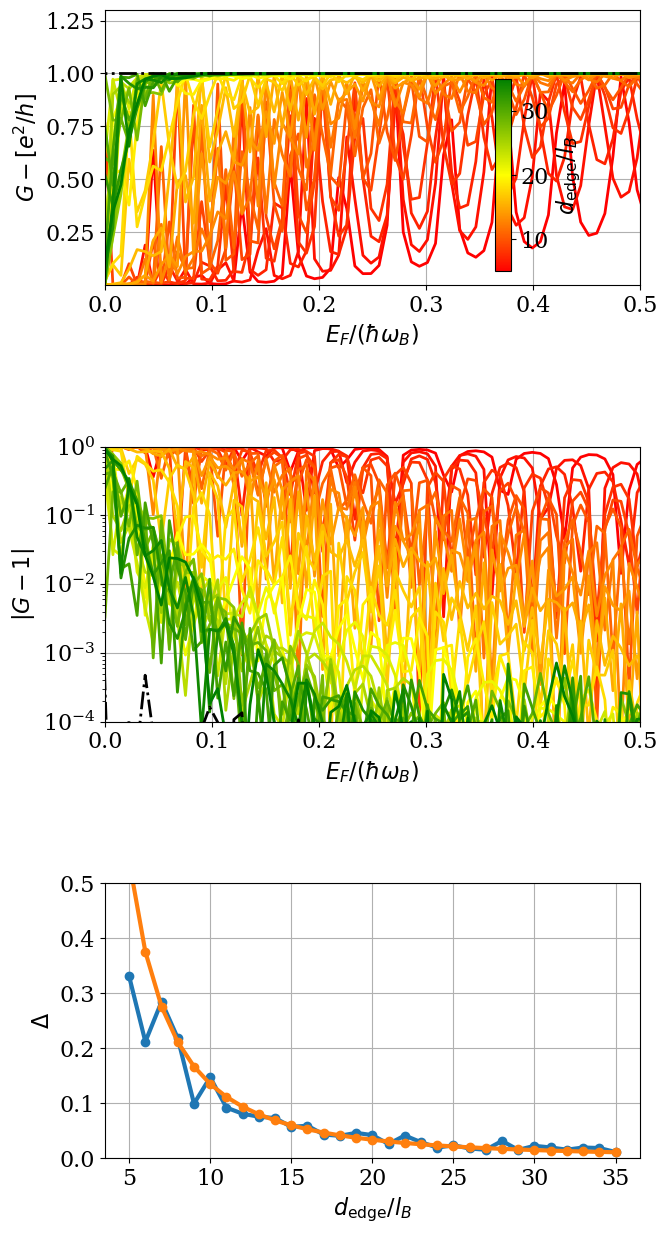

In [87]:
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors


# Second plot (blue curve, right y-axis)
norm = Normalize(vmin=min(distance), vmax=max(distance))  # Normalize gS values
#cmap = plt.get_cmap('coolwarm')  # Color map transitioning from blue to red
cmap = mcolors.LinearSegmentedColormap.from_list("red_to_grey", ["red", "yellow", "green"])

# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))


N_l = 0

for nG in range(NG):
    color = cmap(norm(distance[nG]))
    ax1.plot( (arr_en[nG] - shift_IMG[nG][N_l]) / omB, arrGIMG[nG], color=color, linewidth=2, label='|GIMGT - 2|')

ax1.plot( (arr_en[0]-shift_0[0][N_l] ) / omB, arrG0[0], color='black', linewidth=2, linestyle='-.')


ax1.set_ylabel(r"$G - [e^2/h]$", fontdict=font)
ax1.set_xlabel(r"$E_F/(\hbar\omega_B)$", fontdict=font)


ax1.set_xlim((np.amin(energies)/ omB,np.amax(energies)/omB))
xmin = 0
xmax = .5

ax1.set_ylim((1e-3, 1.3))
#ax1.set_yscale('log')
ax1.set_xlim((xmin, xmax))
ax1.grid()





for nG in range(NG):
    color = cmap(norm(distance[nG]))
    ax2.plot( (arr_en[nG] - shift_IMG[nG][N_l]) / omB, np.abs(arrGIMG[nG] - (1+N_l) ), color=color, linewidth=2, label='|GIMGT - 2|')
for nG in range(NG):
    color = cmap(norm(distance[nG]))
    x = np.flip((arr_en[nG, nef:ne0] - shift_0[nG][0]) / omB)
    ax2.plot(x, np.exp(-x / slope_1[nG] + inter_1[nG]), color=color, linewidth=2, linestyle='-')
    #x = np.linspace(0,1,100)
    #ax2.plot(x, np.exp( - x / arrGam[nG,0] ), color=color, linewidth=2, linestyle='-')

ax2.plot((arr_en[0] - shift_0[0][N_l]) / omB, np.abs(arrG0[0] - (1+N_l)), color='black', linestyle='-.', linewidth=2)

ax2.set_yscale('log')
ax2.set_ylabel(r"$|G - %d|$" % (1+N_l), fontdict=font)
ax2.set_xlabel(r"$E_F/(\hbar\omega_B)$", fontdict=font)

ax2.set_ylim((1e-4, 1e0))
ax2.set_xlim((xmin, xmax))

ax2.grid()

from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Create ScalarMappable for colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)

# Inset for colorbar in ax1
cax = inset_axes(ax1, width="3%", height="70%", loc='center right',
                 bbox_to_anchor=(-.2, -.1, 1, 1), bbox_transform=ax1.transAxes, borderpad=1)

cbar = plt.colorbar(sm, cax=cax)
cbar.set_label(r"$d_{\rm edge}/l_B$")

ax3.plot( distance, slope_1, marker='o', linewidth=3 )
ax3.plot( distance, arrGam[:,0]/3.14, marker='o', linewidth=3 )
ax3.set_xlabel(r'$d_{\rm edge}/l_B$')
ax3.set_ylabel(r'$\Delta $')
ax3.set_ylim(0,0.5)
#ax3.set_xscale('log')
#ax3.set_yscale('log')
ax3.grid()

plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 340 / 25.4)
#plt.savefig('GR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.svg' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))
#plt.savefig('GR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.pdf' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))
plt.show()